In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

import torch
from torch import nn,optim
from torch.utils.data import DataLoader,Dataset
from torchsummary import summary
from torch.autograd import Function
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms.functional as TF

from torchvision import transforms
from PIL import Image
import pickle
from tqdm.notebook import tqdm
import random
from sklearn import metrics
from skimage import io, filters,transform

import model
import baseline_arch as bl

In [2]:
def get_ds_from_pickle_dict(pkl_path):
    with open(pkl_path,'rb') as fp:
        d = pickle.load(fp)
    
    return d

In [3]:
spikelet_count = model.CountEstimate()
spikelet_count_bl = bl.CountEstimate()
spikelet_count.cuda()
spikelet_count_bl.cuda()
''

''

In [4]:
transf = transforms.Compose([transforms.ToTensor()])

In [5]:
spikelet_count.load_state_dict(torch.load('CQ/acid_adapted_to_CQ_final_08.pth'))
spikelet_count_bl.load_state_dict(torch.load('acid_baseline_final_x.pth'))

<All keys matched successfully>

In [6]:
unmasked_target_path = glob.glob('SpikeletFCN_Dataset/unmasked/*.jpg')
masked_target_path = glob.glob('SpikeletFCN_Dataset/masked/*.jpg')
unmasked_target_path

['SpikeletFCN_Dataset/unmasked/Control_Par+N_Rep01_P01_ID-1064_Date-27-6-2016_16-42.jpg',
 'SpikeletFCN_Dataset/unmasked/Control_Par+N_Rep01_P01_ID-1133_Date-28-6-2016_15-55.jpg',
 'SpikeletFCN_Dataset/unmasked/Control_Par+N_Rep01_P01_ID-1055_Date-27-6-2016_13-40.jpg',
 'SpikeletFCN_Dataset/unmasked/Control_Par+N_Rep01_P01_ID-1202_Date-29-6-2016_15-9.jpg',
 'SpikeletFCN_Dataset/unmasked/Control_Par+N_Rep01_P01_ID-1132_Date-28-6-2016_15-35.jpg',
 'SpikeletFCN_Dataset/unmasked/Control_Par+N_Rep01_P01_ID-1193_Date-29-6-2016_12-7.jpg',
 'SpikeletFCN_Dataset/unmasked/Control_Par+N_Rep01_P01_ID-1203_Date-29-6-2016_15-29.jpg',
 'SpikeletFCN_Dataset/unmasked/Control_Par+N_Rep01_P01_ID-1001_Date-26-6-2016_19-29.jpg',
 'SpikeletFCN_Dataset/unmasked/Control_Par+N_Rep01_P01_ID-1060_Date-27-6-2016_15-21.jpg',
 'SpikeletFCN_Dataset/unmasked/Control_Par+N_Rep01_P01_ID-1056_Date-27-6-2016_14-0.jpg',
 'SpikeletFCN_Dataset/unmasked/Control_Par+N_Rep01_P01_ID-1130_Date-28-6-2016_14-55.jpg',
 'SpikeletFCN

In [7]:
gt_count = get_ds_from_pickle_dict('cq_2016_SpikeletFCN.pkl')
gt_mask = get_ds_from_pickle_dict('cq_2016_SpikeletFCN_mask.pkl')

In [17]:
patch_size = 512

In [18]:
gt_n_predictions = []

for img in unmasked_target_path:
    img_name = img.split('/')[-1]
    
    cur_img = io.imread(img)
    cur_mask = gt_mask[img_name]
    
    for i in range(20):
        r,c,d = cur_img.shape

        r_top,c_top = np.random.randint(256,512),np.random.randint(c-patch_size)
        patch_img = transform.resize(cur_img[r_top:r_top+patch_size,c_top:c_top+patch_size],(256,256))
        patch_mask = cur_mask[r_top:r_top+patch_size,c_top:c_top+patch_size]
        
        patch_img_gpu = transf(patch_img).type(torch.FloatTensor).cuda().unsqueeze(0)
        y_hat,_ = spikelet_count(patch_img_gpu)
        y_hat_baseline = spikelet_count_bl(patch_img_gpu)
        
        gt_n_predictions.append([patch_mask.sum(),float(y_hat.sum()),float(y_hat_baseline.sum())])


In [19]:
gt_n_predictions = np.array(gt_n_predictions)

In [20]:
print(metrics.mean_absolute_error(gt_n_predictions[:,0],gt_n_predictions[:,1]))
print(np.sqrt(metrics.mean_squared_error(gt_n_predictions[:,0],gt_n_predictions[:,1])))
print(metrics.r2_score(gt_n_predictions[:,0],gt_n_predictions[:,1]))

207.71806479287923
266.7600673252898
0.43061423010786304


In [21]:
print(metrics.mean_absolute_error(gt_n_predictions[:,0],gt_n_predictions[:,2]))
print(np.sqrt(metrics.mean_squared_error(gt_n_predictions[:,0],gt_n_predictions[:,2])))
print(metrics.r2_score(gt_n_predictions[:,0],gt_n_predictions[:,2]))

469.75297988107894
584.8389671234941
-1.7367654292245769


### Masked

In [178]:
gt_n_predictions = []

for img in masked_target_path:
    img_name = img.split('/')[-1]
    
    cur_img = io.imread(img)
    cur_mask = gt_mask[img_name]
    
    for i in range(20):
        r,c,d = cur_img.shape

        r_top,c_top = np.random.randint(256,512),np.random.randint(c-patch_size)
        patch_img = transform.resize(cur_img[r_top:r_top+patch_size,c_top:c_top+patch_size],(256,256))
        patch_mask = cur_mask[r_top:r_top+patch_size,c_top:c_top+patch_size]
        
        patch_img_gpu = transf(patch_img).type(torch.FloatTensor).cuda().unsqueeze(0)
        y_hat,_ = spikelet_count(patch_img_gpu)
        y_hat_baseline = spikelet_count_bl(patch_img_gpu)
        
        gt_n_predictions.append([patch_mask.sum(),float(y_hat.sum()),float(y_hat_baseline.sum())])
        
gt_n_predictions = np.array(gt_n_predictions)

In [179]:
print(metrics.mean_absolute_error(gt_n_predictions[:,0],gt_n_predictions[:,1]))
print(np.sqrt(metrics.mean_squared_error(gt_n_predictions[:,0],gt_n_predictions[:,1])))

272.22732500076296
330.9140802060355


In [180]:
print(metrics.mean_absolute_error(gt_n_predictions[:,0],gt_n_predictions[:,2]))
print(np.sqrt(metrics.mean_squared_error(gt_n_predictions[:,0],gt_n_predictions[:,2])))

466.0233392079671
568.7262878576462


## Sample

In [120]:
i=0
for img in unmasked_target_path:
    img_name = img.split('/')[-1]
    
    cur_img = io.imread(img)
    cur_mask = gt_mask[img_name]
    

    r,c,d = cur_img.shape

    r_top,c_top = np.random.randint(256,512),np.random.randint(c-patch_size)
    patch_img = transform.resize(cur_img[r_top:r_top+patch_size,c_top:c_top+patch_size],(256,256))
    patch_mask = cur_mask[r_top:r_top+patch_size,c_top:c_top+patch_size]

    patch_img_gpu = transf(patch_img).type(torch.FloatTensor).cuda().unsqueeze(0)
    y_hat,_ = spikelet_count(patch_img_gpu)
    y_hat_baseline = spikelet_count_bl(patch_img_gpu)
    i+=1
    if i == 4:
        break

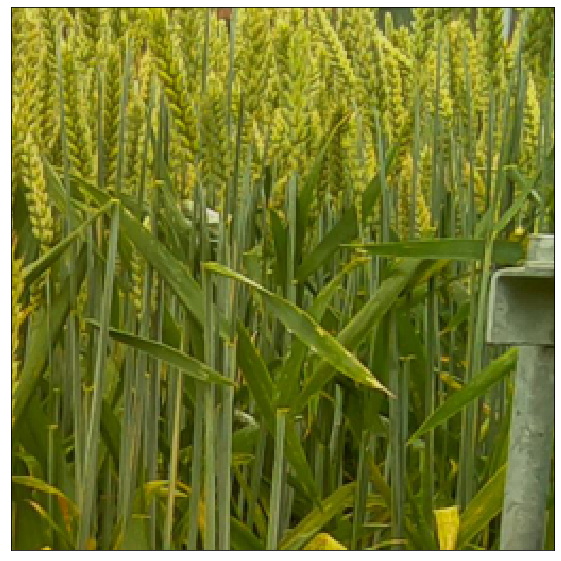

In [121]:
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(patch_img)
plt.savefig('cq_sample_01.png',dpi=100,transparent=True,bbox_inches='tight',pad_inches=0)

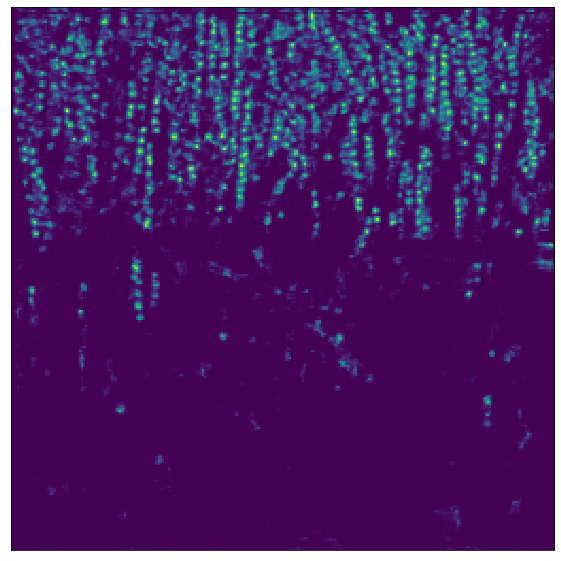

In [122]:
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(y_hat[0,0].cpu().detach().numpy())
plt.savefig('cq_sample_prediction_01.png',dpi=100,transparent=True,bbox_inches='tight',pad_inches=0)

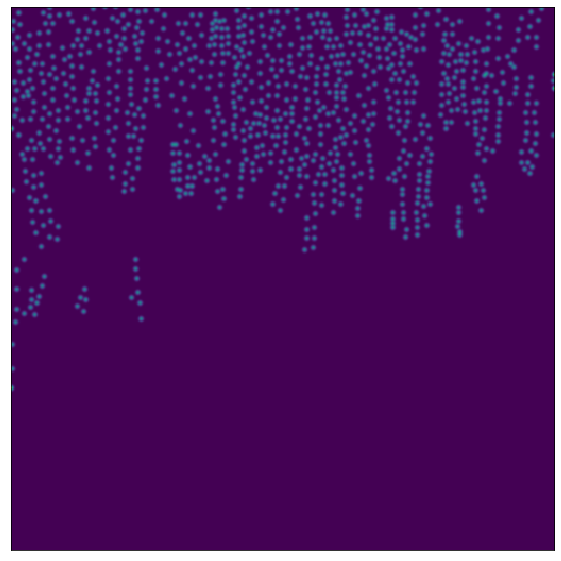

In [125]:
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(filters.gaussian(patch_mask,1.5))
plt.savefig('cq_sample_gt_01.png',dpi=100,transparent=True,bbox_inches='tight',pad_inches=0)

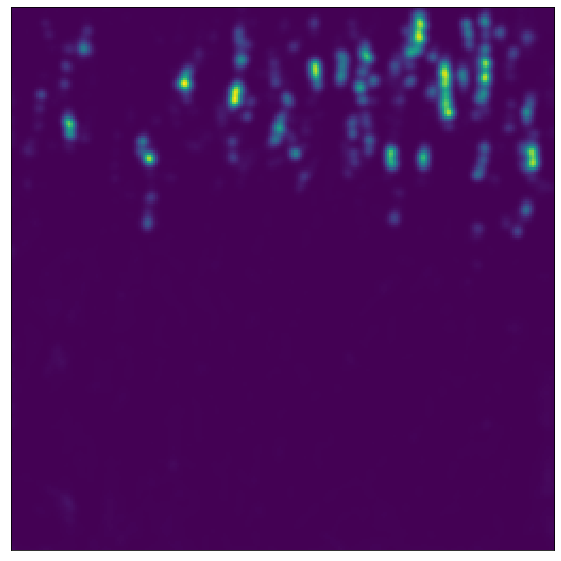

In [126]:
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(filters.gaussian(y_hat_baseline[0,0].cpu().detach().numpy(),1.5))
plt.savefig('cq_sample_bl_01.png',dpi=100,transparent=True,bbox_inches='tight',pad_inches=0)